In [1]:
import os
import sys
from omegaconf import OmegaConf
import importlib
import json
from mpl_toolkits.mplot3d import Axes3D
%matplotlib tk

import torch
import torch.nn as nn

from itertools import product, combinations

from planning.Safe_Planner import *
from nav_sim.env.go1_env import Go1Env

from models import build_model
from datasets import build_dataset

# sys.path.append('../utils')

from nav_sim.test.clustering import cluster
from utils.pc_util import preprocess_point_cloud, read_ply, pc_to_axis_aligned_rep, pc_cam_to_3detr, is_inside_camera_fov
from utils.box_util import box2d_iou
from utils.make_args import make_args_parser

from datasets.sunrgbd import SunrgbdDatasetConfig as dataset_config


/home/zm2074/Documents/anaconda3/envs/pac-perception/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pybullet build time: May 20 2022 19:45:31


Could not import cythonized box intersection. Consider compiling box_intersection.pyx for faster training.


### Sim Code

In [2]:
# task

# get root repository path
nav_sim_path = '/home/zm2074/Projects/perception-guarantees/nav_sim'

# Initialize task
task = OmegaConf.create()
task.init_state = [5, 0.2, 0.0, 0.0]  # x, y, vx, vy
task.goal_loc = [6, 7]
task.goal_radius = 0.7

# obstacles
task.furniture = {}
task.furniture.piece_1 = {
    'path':
        os.path.join(
            nav_sim_path,
            'asset/sample_furniture/00a91a81-fc73-4625-8298-06ecd55b6aaa/raw_model.obj'
        ),
    'position': [2, 4.5, 0.0],
    'yaw': 0
}
task.furniture.piece_2 = {
    'path':
        os.path.join(
            nav_sim_path,
            'asset/sample_furniture/59e52283-361c-4b98-93e9-0abf42686924/raw_model.obj'
        ),
    'position': [3, 6, 0.0],
    'yaw': -np.pi / 2
}
#
task.observation = {}
task.observation.type = 'rgb'  # 'rgb' or 'lidar'
task.observation.rgb = {}
task.observation.depth = {}
task.observation.lidar = {}
task.observation.rgb.x_offset_from_robot_front = 0.01  # no y offset
task.observation.rgb.z_offset_from_robot_top = 0
task.observation.rgb.tilt = 5  # degrees of tilting down towards the floor
task.observation.rgb.img_w = 256
task.observation.rgb.img_h = 256
task.observation.rgb.aspect = 1
task.observation.rgb.fov = 70  # in PyBullet, this is vertical field of view in degrees
task.observation.depth.img_w = task.observation.rgb.img_w  # needs to be the same now - assume coming from the same camera
task.observation.depth.img_h = task.observation.rgb.img_h
task.observation.lidar.z_offset_from_robot_top = 0.01  # no x/y offset
task.observation.lidar.horizontal_res = 1  # resolution, in degree
task.observation.lidar.vertical_res = 1  # resolution, in degree
task.observation.lidar.vertical_fov = 30  # half in one direction, in degree
task.observation.lidar.max_range = 5  # in meter


In [3]:
# planner
# load pre-computed
f = open('planning/reachable_cost5.pkl', 'rb')
reachable = pickle.load(f)
f = open('planning/Pset_cost5.pkl', 'rb')
Pset = pickle.load(f)

# initialize planner
sp = Safe_Planner()
sp.load_reachable(Pset, reachable)

In [4]:
# camera + 3DETR
num_pc_points = 40000

parser = make_args_parser()
args = parser.parse_args(args=[])

# Dataset config: use SUNRGB-D
dataset_config = dataset_config()
# Build model
model, _ = build_model(args, dataset_config)

# Load pre-trained weights
sd = torch.load(args.test_ckpt, map_location=torch.device("cpu")) 
model.load_state_dict(sd["model"]) 

model = model.cuda()
model.eval()

device = torch.device("cuda")

visualize = False

# Load params from json file
with open("env_params.json", "r") as read_file:
    params = json.load(read_file)


In [5]:
env = Go1Env(render=True)

In [6]:
env.reset(task)

argv[0]=--width=2400
argv[1]=--height=1600
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=4
argv[0] = --unused
argv[1] = --width=2400
argv[2] = --height=1600
argv[3] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce RTX 4090/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 545.23.06
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 545.23.06
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce RTX 4090/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


array([[8.00010695e+00, 8.00009870e+00, 8.00009061e+00, ...,
        5.48867026e+00, 5.49257962e+00, 5.49648898e+00],
       [6.62571417e+00, 6.56470375e+00, 6.50492618e+00, ...,
        1.31693918e+00, 1.31693918e+00, 1.31693918e+00],
       [4.01184962e+00, 3.97662523e+00, 3.94211263e+00, ...,
        3.89507092e-03, 3.89507092e-03, 3.89507092e-03]])

In [7]:
def get_box(observation):
    if task.observation.type == 'lidar' or task.observation.type == 'rgb':
        # Filter points with z < 0.01 and abs(y) > 3.5 and x> 0.01 and within a 1m distance of the robot
        # axis transformed, so filter x,y same way
        observation = observation[:, observation[2, :] < 2.9]
        observation = observation[:, observation[0, :] > 0.05]
        observation = observation[:, observation[0, :] < 7.95]
        observation = observation[:, observation[1, :] > 0.05]
        observation = observation[:, observation[1, :] < 7.95]

        visualize = False

        if (len(observation[0])>0):
            # Preprocess point cloud (random sampling of points), if there are any LIDAR returns
            points_new = np.transpose(np.array(observation))
            points = np.zeros((1,num_pc_points, 3),dtype='float32')
            points = preprocess_point_cloud(np.array(points_new), num_pc_points)
        else:
            # There are no returns from the LIDAR, object is not visible
            points = np.zeros((1,num_pc_points, 3),dtype='float32')
        
        # Convert from camera frame to world frame
        point_clouds = []
        point_clouds.append(points)
    
    batch_size = 1
    pc = np.array(point_clouds).astype('float32')
    pc = pc.reshape((batch_size, num_pc_points, 3))

    pc_all = torch.from_numpy(pc).to(device)
    pc_min_all = pc_all.min(1).values
    pc_max_all = pc_all.max(1).values
    inputs = {'point_clouds': pc_all, 'point_cloud_dims_min': pc_min_all, 'point_cloud_dims_max': pc_max_all}

    # start = tm.time()
    outputs = model(inputs)
    # end = tm.time()
    # print("Time taken for inference: ", end-start)
    
    bbox_pred_points = outputs['outputs']['box_corners'].detach().cpu()
    cls_prob = outputs["outputs"]["sem_cls_prob"].clone().detach().cpu()

    chair_prob = cls_prob[:,:,3]
    sort_box = torch.sort(chair_prob,1,descending=True)

    # Visualize
    if visualize:
        pc_plot = pc[:, pc[0,:,2] > 0.0,:]
        plt.figure()
        ax = plt.axes(projection='3d')
        ax.scatter3D(
            pc_plot[0,:,0], pc_plot[0,:,1],pc_plot[0,:,2]
        )
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_aspect('equal')

    num_probs = 0
    num_boxes = 5
    corners = []
    for (sorted_idx,prob) in zip(list(sort_box[1][0,:]), list(sort_box[0][0,:])):
        if (num_probs < num_boxes):
            prob = prob.numpy()
            bbox = bbox_pred_points[range(batch_size), sorted_idx, :, :]
            cc = pc_to_axis_aligned_rep(bbox.numpy())
            flag = False
            if num_probs == 0:
                corners.append(cc)
                num_probs +=1
            else:
                for cc_keep in corners:
                    bb1 = (cc_keep[0,0,0],cc_keep[0,0,1],cc_keep[0,1,0],cc_keep[0,1,1])
                    bb2 = (cc[0,0,0],cc[0,0,1],cc[0,1,0],cc[0,1,1])
                    # Non-maximal supression, check if IoU more than some threshold to keep box
                    if(box2d_iou(bb1,bb2) > 0.1):
                        flag = True
                if not flag:    
                    corners.append(cc)
                    num_probs +=1

            if visualize:
                r0 = [cc[0,0, 0], cc[0,1, 0]]
                r1 = [cc[0,0, 1], cc[0,1, 1]]
                r2 = [cc[0,0, 2], cc[0,1, 2]]

                for s, e in combinations(np.array(list(product(r0, r1, r2))), 2):
                    if (np.sum(np.abs(s-e)) == r0[1]-r0[0] or 
                        np.sum(np.abs(s-e)) == r1[1]-r1[0] or 
                        np.sum(np.abs(s-e)) == r2[1]-r2[0]):
                        if (visualize and not flag):
                            ax.plot3D(*zip(s, e), color=(0.5+0.5*prob, 0.1,0.1))
    
    boxes = np.zeros((len(corners),2,2))
    for i in range(len(corners)):
        boxes[i,:,:] = corners[i][0,:,0:2]

    return boxes

In [8]:
t = 0
cp = 0.8
observation = env.step([0,0])[0] # initial observation
while True:
    state = np.array(env._state)
    boxes = get_box(observation)
    boxes[:,0,:] -= cp
    boxes[:,1,:] += cp

    res = sp.plan(state, boxes)
    if len(res[0]) != 1:
        policy = np.vstack(res[2])
        for step in range(int(sp.sensor_dt/sp.dt)):
            action = policy[step]
            observation, reward, done, info = env.step(action)
            # summarize the step in one line
            # print('\nStep:{}, Action:{}, Done:{}, {}'.format(
            #         step, action, done, info))
            t += sp.sensor_dt
            if done:
                break
    else:
        for step in range(int(sp.sensor_dt/sp.dt)):
            action = [0,0]
            observation, reward, done, info = env.step(action)
            t += sp.sensor_dt
    if t >100:
        break

goal reached
planning time:  0.2289586067199707
goal reached
planning time:  0.29665231704711914
goal reached
planning time:  0.27803850173950195
goal reached
planning time:  0.213731050491333
goal reached
planning time:  0.15463972091674805
intermediate goal:  [ 5.25855133  4.13860867 -0.06013742  1.80232434]
intermediate goal:  [4.41753976 4.67580855 1.84774551 0.58429505]
intermediate goal:  [ 3.38923839  5.1671529  -0.24965115  1.783546  ]
intermediate goal:  [ 2.79918144  5.65128462 -1.9016919   1.26797384]
intermediate goal:  [ 1.71068277  6.1698037  -1.95131537  0.64565908]
intermediate goal:  [ 0.9211028   6.54991267 -0.58714493  1.96613374]
intermediate goal:  [6.1397261  4.13466432 1.93170591 0.28811708]
intermediate goal:  [7.04882558 4.65018298 1.52694145 1.38506318]
planning failed, stay
planning time:  0.576801061630249
intermediate goal:  [6.16102499 4.01684465 1.144754   1.4960456 ]
intermediate goal:  [ 5.18041946  4.50419069 -1.31343673  1.58906202]
intermediate goal:

In [9]:
sp.world.isValid([5,0.2])

False

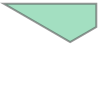

In [10]:
sp.world.free_space